# Text Analysis

In [1]:
import pandas as pd
from tqdm import tqdm

# Sentiment Analysis
# from keras_preprocessing.sequence import pad_sequences
# from sentita import calculate_polarity

# Emotion Analysis
from feel_it import EmotionClassifier

# Toxicity Analysis
from detoxify import Detoxify

import re
import urllib.parse

import matplotlib.pyplot as plt

In [2]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
                     # nrows = 400000,
                     parse_dates=['created_at'],
                     converters={"user_id": str,
                                 "tweet_id": str},
                     date_parser=dateparse,
                     lineterminator='\n')

scores = pd.read_csv("../data/scores_tweets.csv",
                    converters={"tweet_id": str})

newsguard_scores = pd.read_csv("../data/newsguard_scores.csv", #path/to/newsguard_scores_file
                              converters={"name": str},
                              lineterminator='\n')

scores = scores[(scores['tweet_id'].isin(tweets['tweet_id']))]

# Converti la colonna 'score' in float, convertendo i valori non validi in NaN
newsguard_scores['score'] = pd.to_numeric(newsguard_scores['score'], errors='coerce')

C:\Users\davis\AppData\Local\Temp\ipykernel_29168\3305450361.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file
C:\Users\davis\AppData\Local\Temp\ipykernel_29168\3305450361.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("../data/sample_tweets.csv", #path/to/tweets_file


In [3]:
# Commentare se si vogliono usare gli scores calcolati e non quelli importati
tweets = tweets.merge(scores, on='tweet_id', how='left')

tweets_copy = tweets.copy()

## Preprocessing

In [4]:
# Sostituisci i valori NaN con '' nelle colonne 'text', 'retweeted_text' e 'quoted_text'
tweets_copy['text'] = tweets_copy['text'].fillna('')
tweets_copy['retweeted_text'] = tweets_copy['retweeted_text'].fillna('')
tweets_copy['quoted_text'] = tweets_copy['quoted_text'].fillna('')

# Assicurati che tutti i valori nelle colonne 'text', 'retweeted_text' e 'quoted_text' siano stringhe
tweets_copy['text'] = tweets_copy['text'].astype(str)
tweets_copy['retweeted_text'] = tweets_copy['retweeted_text'].astype(str)
tweets_copy['quoted_text'] = tweets_copy['quoted_text'].astype(str)

# Crea tre dataframe separati per 'text', 'retweeted_text' e 'quoted_text'
text_df = tweets_copy[['tweet_id', 'text']].rename(columns={'text': 'all_text'})
retweeted_text_df = tweets_copy[['tweet_id', 'retweeted_text']].rename(columns={'retweeted_text': 'all_text'})
quoted_text_df = tweets_copy[['tweet_id', 'quoted_text']].rename(columns={'quoted_text': 'all_text'})

# Concatena i dataframe
all_text_df = pd.concat([text_df, retweeted_text_df, quoted_text_df])

# Elimina le righe con all_text vuoto o nan
all_text_df = all_text_df[all_text_df['all_text'].notna() & (all_text_df['all_text'] != '')]


In [16]:
# all_text_df.to_csv('../data/sample_tweets_only_text.csv', index=False)

## Sentiment Analysis

### SentITA

In [ ]:
sentiments = []
for index, row in tqdm(all_text_df.iterrows(), total=all_text_df.shape[0]):
    sentence = row['all_text']
    results, polarities = calculate_polarity([sentence])
    sentiment = {
        'Positive': polarities[0][0],
        'Negative': polarities[0][1]
    }
    sentiments.append(sentiment)

all_text_df['Sentiment'] = sentiments

all_text_df

In [ ]:
for index, row in all_text_df.iterrows():
    sentiment = row['Sentiment']
    positive_score = sentiment['Positive']
    negative_score = sentiment['Negative']
    print(f"Positive score: {positive_score}, Negative score: {negative_score}")


### Imported Scores

#### Positive Score

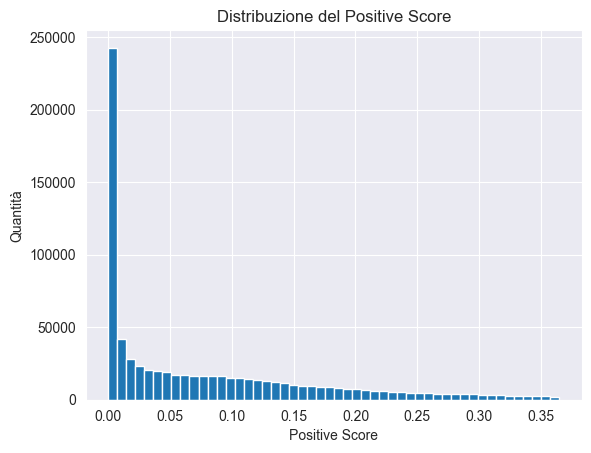

In [7]:
tweets_copy = tweets.copy()

# Rimuovi righe con NaN nella colonna 'positive_y'
tweets_copy = tweets_copy.dropna(subset=['positive_y'])

# Istogramma per 'positive_y'
# plt.figure(figsize=(10, 5))
plt.hist(tweets_copy['positive_y'], bins=50, range=(0, tweets_copy['positive_y'].quantile(0.90)))
plt.xlabel('Positive Score')
plt.ylabel('Quantità')
plt.title('Distribuzione del Positive Score')
plt.show()


#### Negative Score

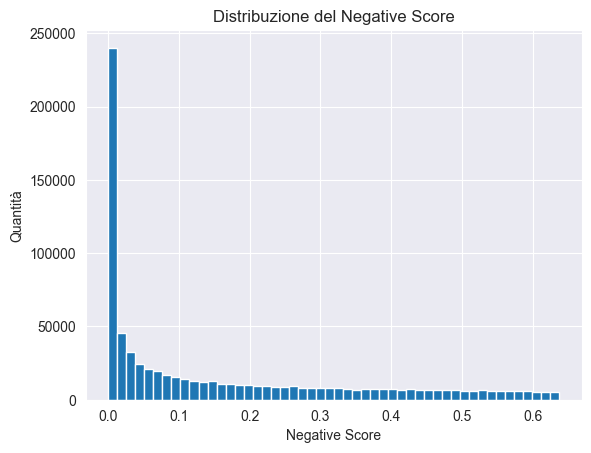

In [15]:
tweets_copy = tweets.copy()

# Rimuovi righe con NaN nella colonna 'negative_y'
tweets_copy = tweets_copy.dropna(subset=['negative_y'])

# Istogramma per 'negative_y'
# plt.figure(figsize=(10, 5))
plt.hist(tweets_copy['negative_y'], bins=50, range=(0, tweets_copy['negative_y'].quantile(0.90)))
plt.xlabel('Negative Score')
plt.ylabel('Quantità')
plt.title('Distribuzione del Negative Score')
plt.show()


## Emotion Analysis

### FEEL-IT

In [14]:
all_text_df = all_text_df.apply(lambda x: x[:1000])
all_text_df
# all_text_df.to_csv('../data/sample_tweets_only_text_small.csv', index=False)

,tweet_id,all_text
5,1340466213240135682,@maxdantoni E questo è quello che dice il Brit...
7,1340466401111388162,🚫💉\n\n#vaccination #vaccinations #vaccinatie...
8,1340466489401503749,"Quanta confusione con i vaccini,ci sono gli ef..."
11,1340466830633267205,"Covid-20, datemi un vaccino nel giro di un qua..."
12,1340466917975461893,Quando stava per arrivare il vaccino ma lui va...
...,...,...
2704,1340581560517599232,💉🤔🙄......😵🤬\n😷 &lt; -- 2m -- &gt; 🧼!!! 🤷🏻‍♀...
2707,1340581595556835329,#vaccinoCovid sarebbe meglio attivare un piano...
2712,1340581721566228486,@Corriere Ci credo poco.\nComunque sarà una va...
2713,1340581727039840256,@de_basso @Gianmar26145917 @Totopri2 Banche a ...


In [11]:
emotion_classifier = EmotionClassifier()

emotions = []
for index, row in tqdm(all_text_df.iterrows(), total=all_text_df.shape[0]):
    sentence = [row['all_text']]
    emotion = emotion_classifier.predict(sentence)[0]
    emotions.append(emotion)

all_text_df['emotion'] = emotions

# all_text_df.to_csv('../data/emotion_score.csv', index=False)

all_text_df


100%|██████████| 1000/1000 [01:39<00:00, 10.10it/s]


,tweet_id,all_text,emotion
5,1340466213240135682,@maxdantoni E questo è quello che dice il Brit...,fear
7,1340466401111388162,🚫💉\n\n#vaccination #vaccinations #vaccinatie...,fear
8,1340466489401503749,"Quanta confusione con i vaccini,ci sono gli ef...",anger
11,1340466830633267205,"Covid-20, datemi un vaccino nel giro di un qua...",fear
12,1340466917975461893,Quando stava per arrivare il vaccino ma lui va...,sadness
...,...,...,...
2704,1340581560517599232,💉🤔🙄......😵🤬\n😷 &lt; -- 2m -- &gt; 🧼!!! 🤷🏻‍♀...,joy
2707,1340581595556835329,#vaccinoCovid sarebbe meglio attivare un piano...,fear
2712,1340581721566228486,@Corriere Ci credo poco.\nComunque sarà una va...,fear
2713,1340581727039840256,@de_basso @Gianmar26145917 @Totopri2 Banche a ...,anger


In [15]:
emotion_classifier = EmotionClassifier()

emotions = []
batch_size = 100

# Creazione dei batch
for i in tqdm(range(0, all_text_df.shape[0], batch_size)):
    batch = all_text_df.iloc[i:i+batch_size]['all_text'].tolist()
    batch_emotions = emotion_classifier.predict(batch)
    emotions.extend(batch_emotions)

all_text_df['emotion'] = emotions
# all_text_df.to_csv('../data/emotion_score.csv', index=False)
all_text_df


100%|██████████| 10/10 [03:19<00:00, 19.98s/it]


,tweet_id,all_text,emotion
5,1340466213240135682,@maxdantoni E questo è quello che dice il Brit...,fear
7,1340466401111388162,🚫💉\n\n#vaccination #vaccinations #vaccinatie...,fear
8,1340466489401503749,"Quanta confusione con i vaccini,ci sono gli ef...",anger
11,1340466830633267205,"Covid-20, datemi un vaccino nel giro di un qua...",fear
12,1340466917975461893,Quando stava per arrivare il vaccino ma lui va...,sadness
...,...,...,...
2704,1340581560517599232,💉🤔🙄......😵🤬\n😷 &lt; -- 2m -- &gt; 🧼!!! 🤷🏻‍♀...,joy
2707,1340581595556835329,#vaccinoCovid sarebbe meglio attivare un piano...,fear
2712,1340581721566228486,@Corriere Ci credo poco.\nComunque sarà una va...,fear
2713,1340581727039840256,@de_basso @Gianmar26145917 @Totopri2 Banche a ...,anger


### Imported Emotions

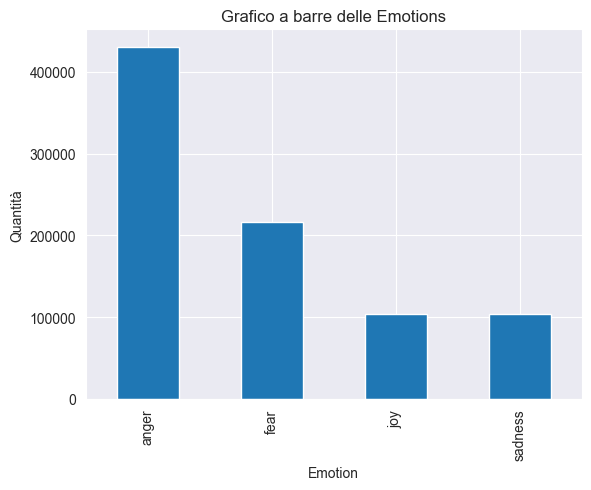

In [10]:
tweets_copy = tweets.copy()

# Rimuovi righe con NaN nella colonna 'emotion'
tweets_copy = tweets_copy.dropna(subset=['emotion'])

# Conta le frequenze delle diverse emozioni
emotion_counts = tweets_copy['emotion'].value_counts()

# Grafico a barre per 'emotion'
# plt.figure(figsize=(10, 5))
emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Quantità')
plt.title('Grafico a barre delle Emotions')
plt.show()


## Toxicity Analysis

### Detoxify

In [6]:
model = Detoxify('multilingual')

toxicities = []
for index, row in tqdm(all_text_df.iterrows(), total=all_text_df.shape[0]):
    sentence = row['all_text']
    toxicity = model.predict(sentence)
    toxicities.append(toxicity)

all_text_df['toxicity'] = toxicities

all_text_df


Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to C:\Users\davis/.cache\torch\hub\checkpoints\multilingual_debiased-0b549669.ckpt


  0%|          | 0.00/1.04G [00:00<?, ?B/s]

  1%|          | 37724/4640204 [1:22:32<312:05:35,  4.10it/s]

### Imported Scores

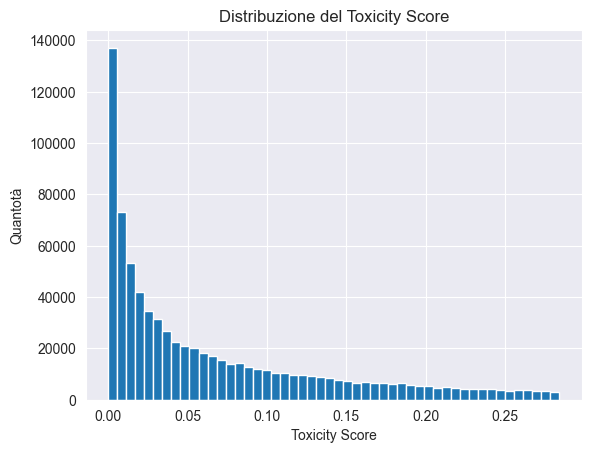

In [11]:
tweets_copy = tweets.copy()

# Rimuovi righe con NaN nella colonna 'toxicity'
tweets_copy = tweets_copy.dropna(subset=['toxicity'])

# Istogramma per 'toxicity'
# plt.figure(figsize=(10, 5))
plt.hist(tweets_copy['toxicity'], bins=50, range=(0, tweets_copy['toxicity'].quantile(0.90)))
plt.xlabel('Toxicity Score')
plt.ylabel('Quantotà')
plt.title('Distribuzione del Toxicity Score')
plt.show()


## Misinformation Analysis

In [16]:
# Funzione per estrarre domini dai link
def extract_domain(link_list):
    if link_list:  # Se la lista non è vuota
        link = link_list[0]
        parsed_uri = urllib.parse.urlparse(link)
        domain = '{uri.netloc}'.format(uri=parsed_uri)
        return domain
    else:  # Se la lista è vuota
        return None

# Estrai tutti i link dai tweet
all_text_df['link'] = all_text_df['all_text'].apply(lambda x: re.findall(r'(https?://[^\s]+)', x))

# Estrai il dominio da ogni link
all_text_df['domain'] = all_text_df['link'].apply(extract_domain)

# Unisci i tweet con newsguard_score in base al dominio
all_text_df = all_text_df.merge(newsguard_scores, left_on='domain', right_on='name', how='left')

all_text_df


,tweet_id,all_text,polarity,subjectivity,neg,neu,pos,compound,link,domain,name,score
0,1340466213240135682,@maxdantoni E questo è quello che dice il Brit...,0.0,0.0,0.073,0.927,0.000,-0.4588,[https://t.co/XF1BegpbKd],t.co,NaN,NaN
1,1340466401111388162,🚫💉\n\n#vaccination #vaccinations #vaccinatie...,0.0,0.0,0.000,1.000,0.000,0.0000,[https://t.co/2DVh4RmwVX],t.co,NaN,NaN
2,1340466489401503749,"Quanta confusione con i vaccini,ci sono gli ef...",0.0,0.0,0.000,1.000,0.000,0.0000,[],None,NaN,NaN
3,1340466830633267205,"Covid-20, datemi un vaccino nel giro di un qua...",0.0,0.0,0.000,1.000,0.000,0.0000,[https://t.co/u2egYIILPp],t.co,NaN,NaN
4,1340466917975461893,Quando stava per arrivare il vaccino ma lui va...,0.0,0.0,0.000,1.000,0.000,0.0000,[https://t.co/G9lVkvCIC2],t.co,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4640199,1375753714338828289,"Questa risposta da sola, all'interno delle FAQ...",0.0,0.0,0.000,1.000,0.000,0.0000,"[https://t.co/luwO2GBCfc, https://t.co/30NbbTF...",t.co,NaN,NaN
4640200,1375753786413694978,NOVO MENE DAS VACINAS BRASILEIRAS https://t.co...,0.0,0.0,0.000,1.000,0.000,0.0000,[https://t.co/5OihXD939x],t.co,NaN,NaN
4640201,1375753788640931840,"""Brusaferro"":\nPerché in un'intervista al @Cor...",0.0,0.0,0.000,0.936,0.064,0.3400,[https://t.co/n4sfzBojMv],t.co,NaN,NaN
4640202,1375753790788362240,Draghi e Speranza motivano la scelta sulle scu...,0.0,0.0,0.000,1.000,0.000,0.0000,[],None,NaN,NaN
